In [1]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import alphashape

root = Tk()
root.withdraw()

# read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

# data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]

# meta_data
train_ID = train_df["meta_ID"]
test_ID = test_df["meta_ID"]


# Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


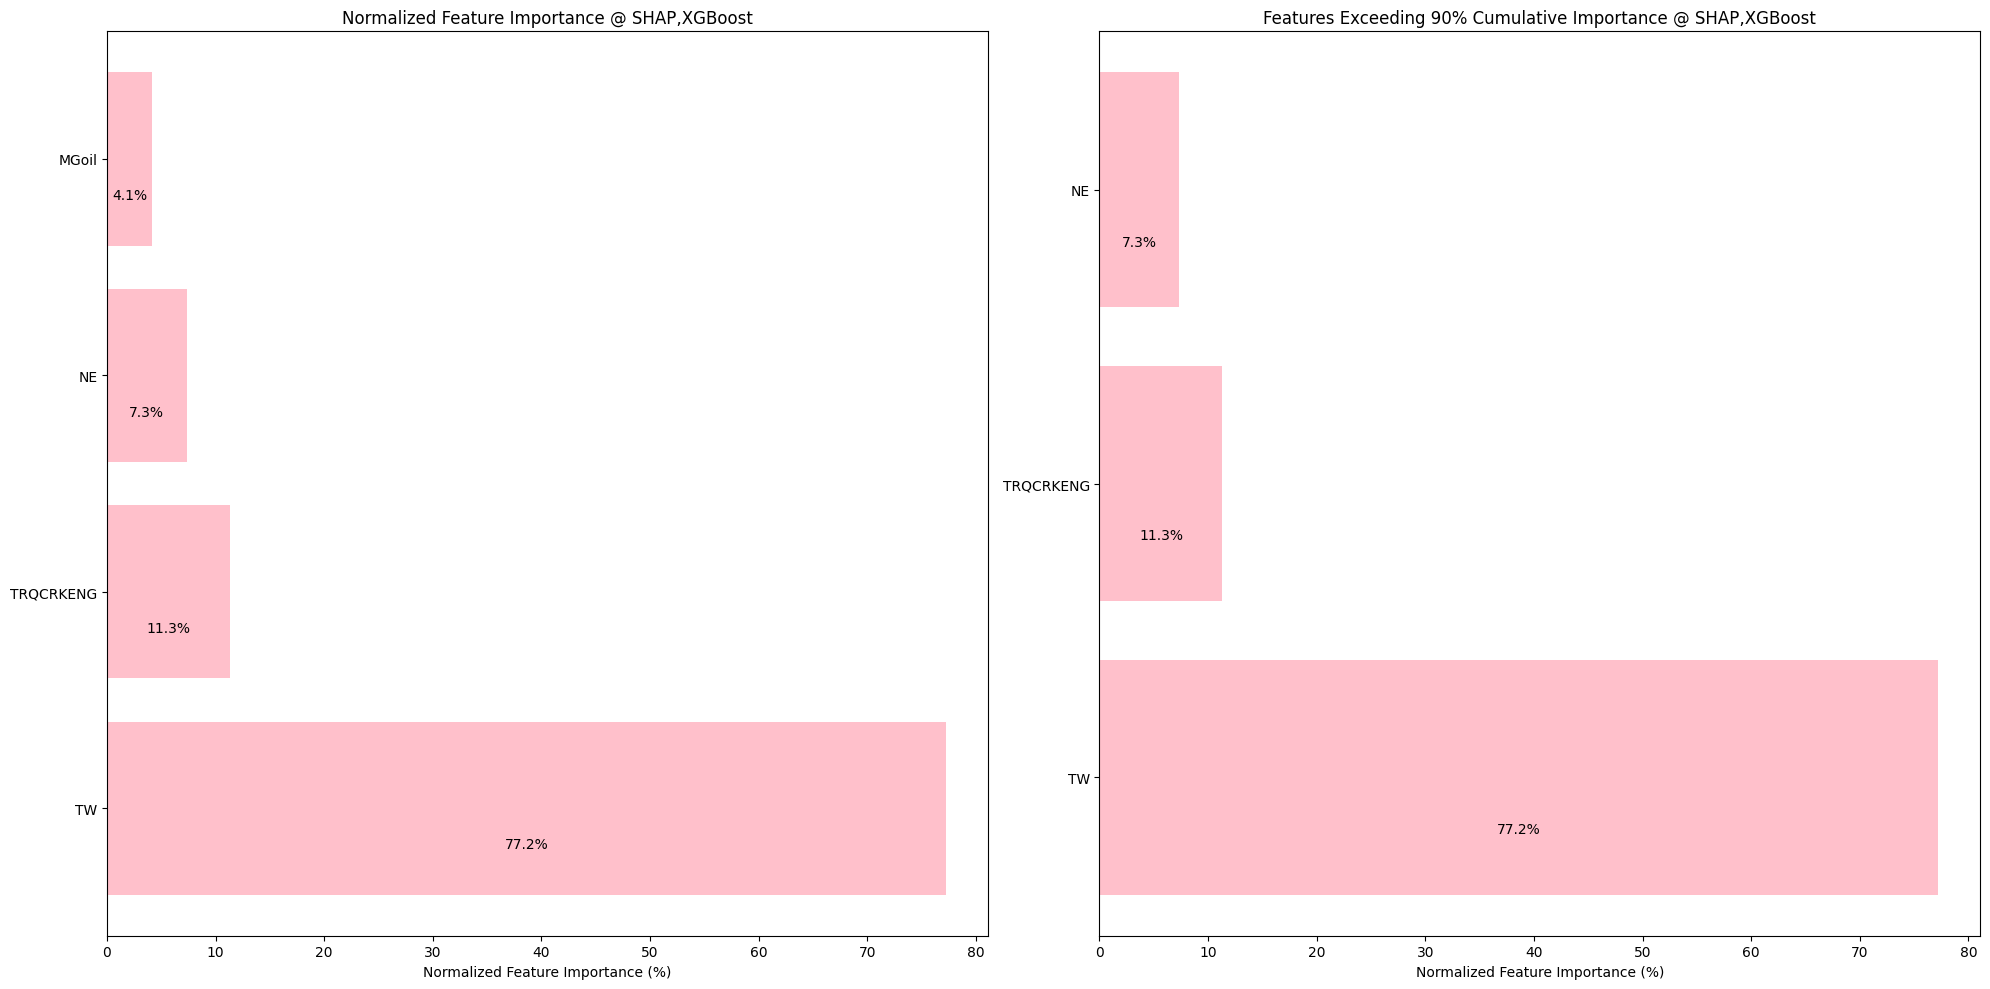

In [2]:
# モデル訓練
model = xgb.XGBRegressor(n_jobs=-1)
model.fit(train_data, target_data)

# SHAP値の計算
explainer = shap.Explainer(model)
shap_values = explainer(train_data)

# 特徴量の重要度とソート
feature_importance = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(-feature_importance)
sorted_importance = feature_importance[sorted_idx]

# 正規化
normalized_importance = (sorted_importance / np.sum(sorted_importance)) * 100

# 累計寄与度が90%を超えるまでの特徴量を選択
cumulative_importance = np.cumsum(sorted_importance / np.sum(sorted_importance))
selected_features_idx = np.where(cumulative_importance > 0.9)[0][0]
selected_features = [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)]
selected_normalized_importance = normalized_importance[:selected_features_idx + 1]

# 1行2列でプロット
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# すべての特徴量を表示
axes[0].barh(range(len(sorted_idx)), normalized_importance, align='center', color='pink')
axes[0].set_yticks(range(len(sorted_idx)))
axes[0].set_yticklabels([feature_vars[i] for i in sorted_idx])
axes[0].set_xlabel('Normalized Feature Importance (%)')
axes[0].set_title('Normalized Feature Importance @ SHAP,XGBoost')

bars = axes[0].patches
for bar in bars:
    axes[0].text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

# 累計寄与度が90%を超える特徴量だけを表示
axes[1].barh(range(len(selected_features)), selected_normalized_importance, align='center', color='pink')
axes[1].set_yticks(range(len(selected_features)))
axes[1].set_yticklabels([feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)])
axes[1].set_xlabel('Normalized Feature Importance (%)')
axes[1].set_title('Features Exceeding 90% Cumulative Importance @ SHAP,XGBoost')

bars = axes[1].patches
for bar in bars:
    axes[1].text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

plt.tight_layout()
plt.show()


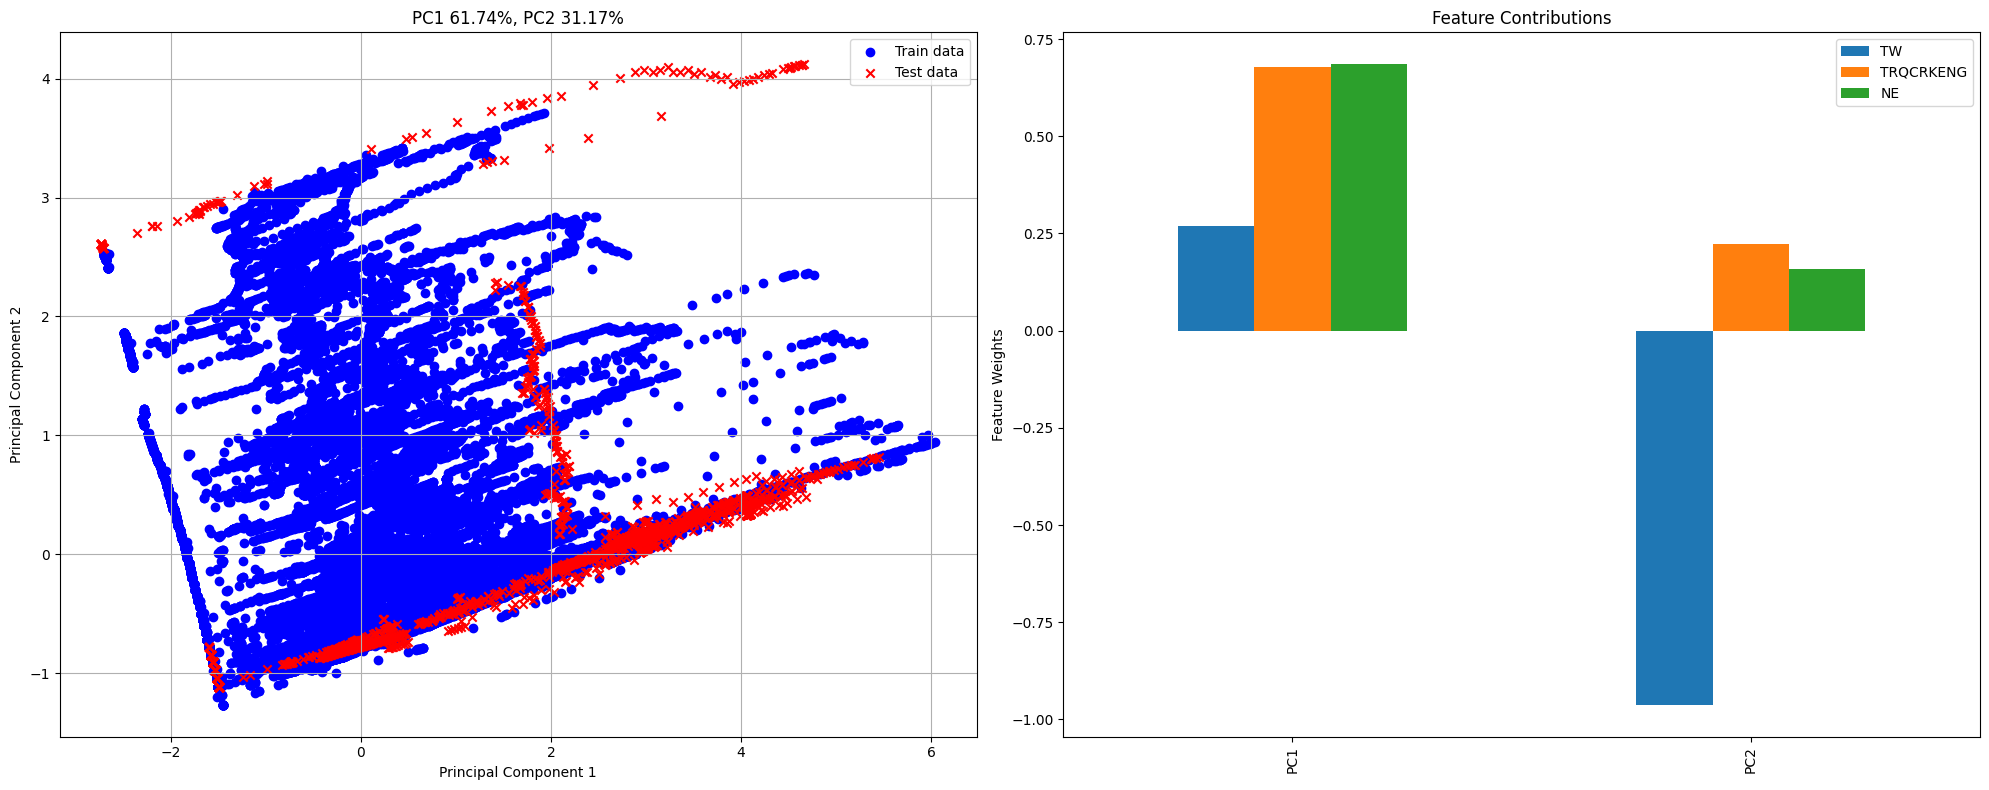

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# PCA
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(selected_train_data)
pca_test_data = pca.transform(selected_test_data)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Visualize PCA
ax = axes[0]
ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data') 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# 分散寄与度計算
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio1 = explained_variance_ratio[0] * 100
explained_variance_ratio2 = explained_variance_ratio[1] * 100

ax.set_title(f'PC1 {explained_variance_ratio1:.2f}%, PC2 {explained_variance_ratio2:.2f}%')
ax.legend(loc='upper right')
ax.grid(True)

# feature contribution
components_df = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Visualize
ax = axes[1]
components_df.iloc[:2, :].plot(kind='bar', ax=ax)
ax.set_title('Feature Contributions')
ax.set_ylabel('Feature Weights')

plt.tight_layout()
plt.show()


For alpha=0, number of outsider_test_indices: 115
For alpha=0, number of boundary_train_indices: 199
For alpha=0, number of boundary_train_indices: 199
For alpha=1, number of outsider_test_indices: 637
For alpha=1, number of boundary_train_indices: 2758
For alpha=1, number of boundary_train_indices: 2758
For alpha=2, number of outsider_test_indices: 643
For alpha=2, number of boundary_train_indices: 3345
For alpha=2, number of boundary_train_indices: 3345
For alpha=3, number of outsider_test_indices: 649
For alpha=3, number of boundary_train_indices: 3498
For alpha=3, number of boundary_train_indices: 3498


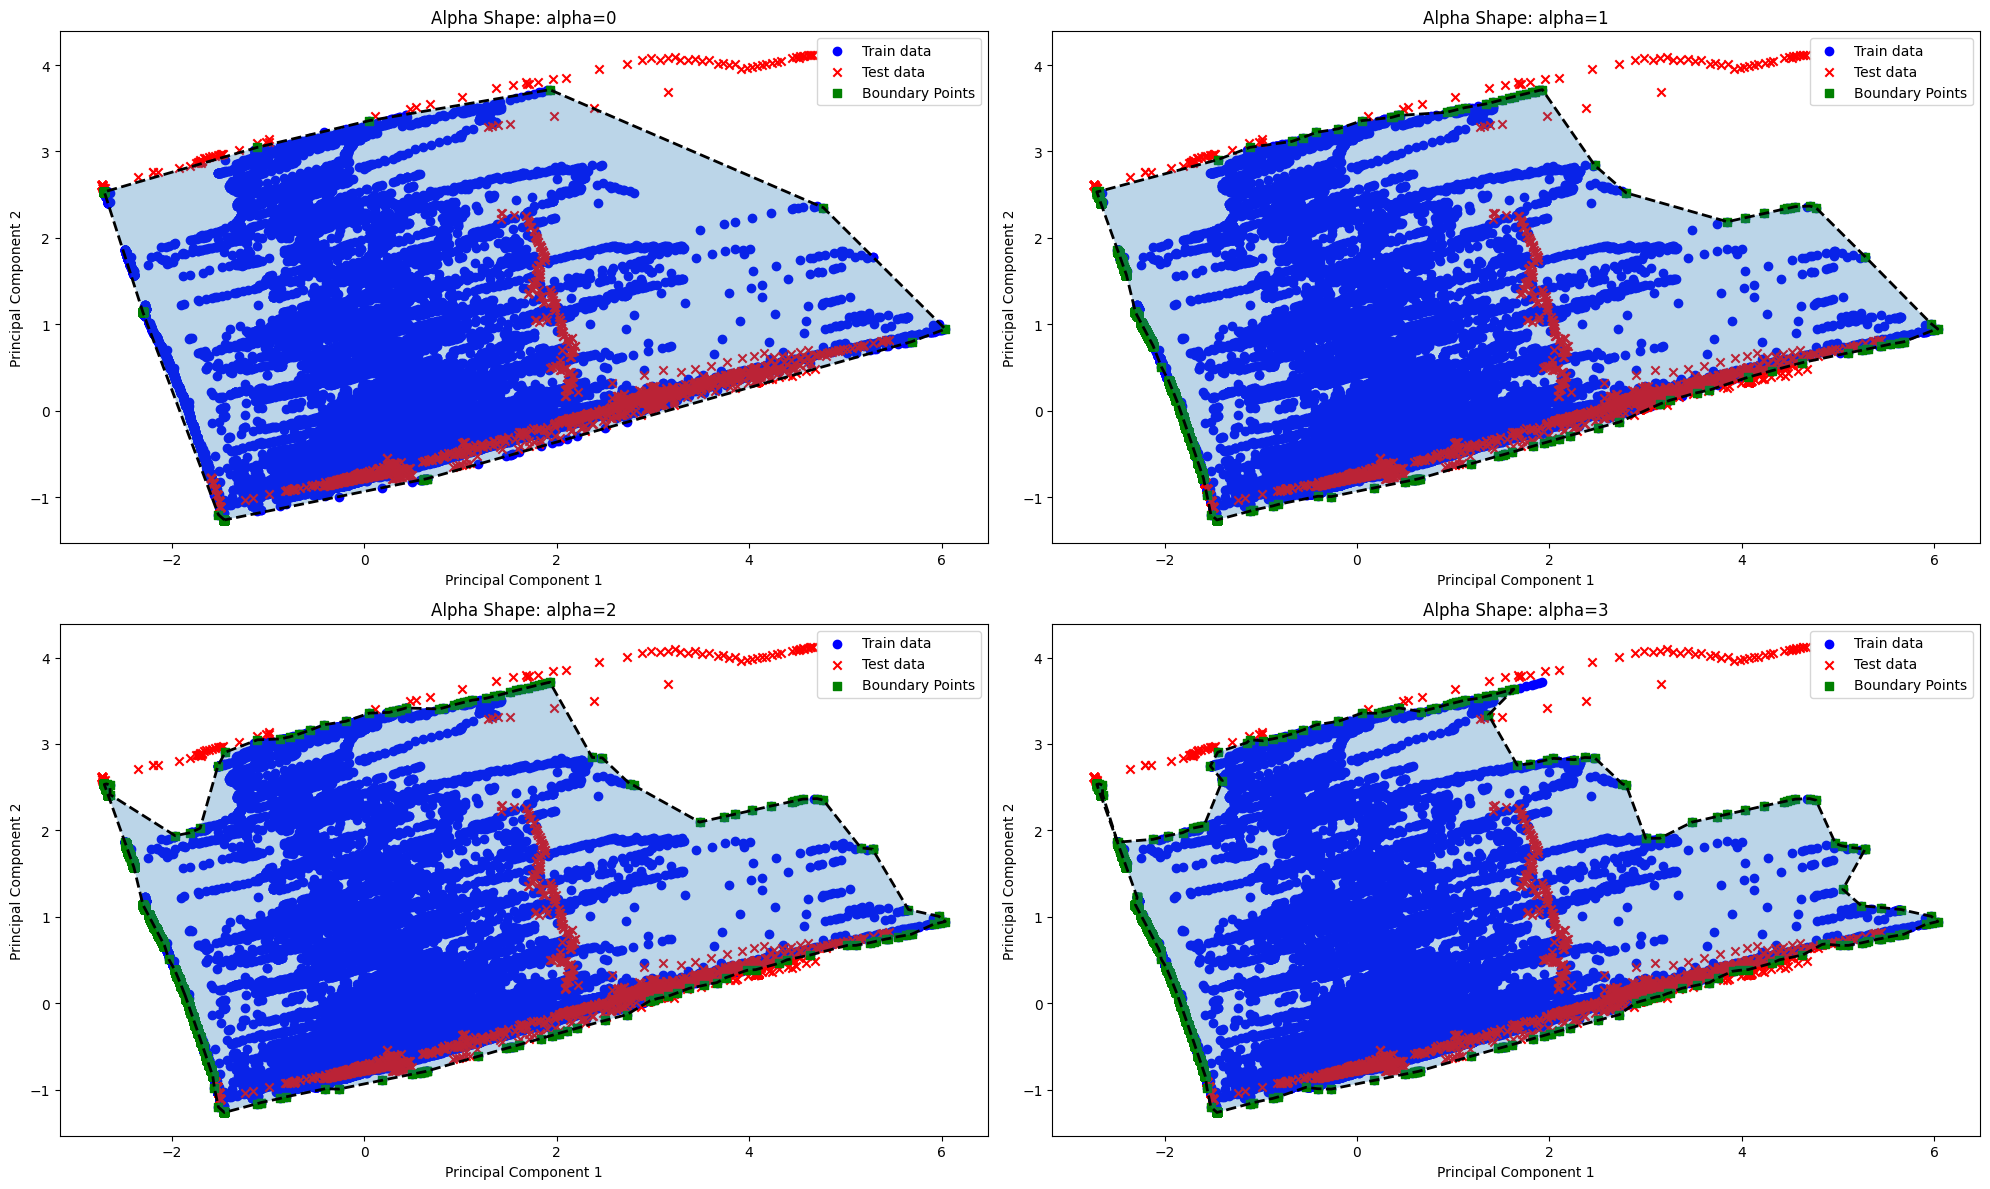

In [8]:
from shapely.geometry import MultiPoint, Point, shape
from alphashape import alphashape

# alpha_shape外形に対しpointとの距離がthresholdよりも小さければTrueを返す
def is_near_boundary(point, alpha_shape, threshold=1e-5):
    point = Point(point)
    return alpha_shape.boundary.distance(point) < threshold

# Initialize
outsider_test_points = {}
boundary_train_points = {}
original_boundary_train_points = {}
original_boundary_train_IDs = {}
original_outsider_test_points = {}
original_outsider_test_IDs = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, alpha_value in enumerate(range(0, 4)):
    ax = axes[i//2, i%2]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # outside : alpha shape
    outsider_test_indices = [not alpha_shape.contains(Point(point)) for point in pca_test_data]
    outsider_test_points[alpha_value] = pca_test_data[np.where(outsider_test_indices)]
    
    # boundary : alpha shape
    boundary_train_indices = [is_near_boundary(point, alpha_shape) for point in pca_train_data]
    boundary_train_points[alpha_value] = pca_train_data[np.where(boundary_train_indices)] #True判定されたデータをpca_train_dataから検索
    
    print(f"For alpha={alpha_value}, number of outsider_test_indices: {np.sum(outsider_test_indices)}")
    print(f"For alpha={alpha_value}, number of boundary_train_indices: {np.sum(boundary_train_indices)}")

    # 元の特徴空間でのデータ
    original_boundary_train_points[alpha_value] = train_data[selected_features].iloc[np.where(boundary_train_indices)[0]] #高次元空間を低次元に写像する際、データ数・順序は変わりないので、このindexを利用する手法で問題なし
    original_boundary_train_IDs[alpha_value] = train_ID.iloc[np.where(boundary_train_indices)[0]]

    # 元の特徴空間でのデータ
    original_outsider_test_points[alpha_value] = test_data[selected_features].iloc[np.where(outsider_test_indices)[0]]
    original_outsider_test_IDs[alpha_value] = test_ID.iloc[np.where(outsider_test_indices)[0]]

    # Plotting
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')
    ax.scatter(boundary_train_points[alpha_value][:, 0], boundary_train_points[alpha_value][:, 1], c='green', marker='s', label='Boundary Points')
    #ax.scatter(outsider_test_points[alpha_value][:, 0], outsider_test_points[alpha_value][:, 1], c='purple', marker='^', label='Outsider Test Points')

    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)

    ax.set_title(f'Alpha Shape: alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


In [10]:
import plotly.graph_objects as go

# Calculating Convex Hull
points = train_data[selected_features].to_numpy()
hull = ConvexHull(points)

fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add mesh for Convex Hull
fig.add_trace(go.Mesh3d(x=points[:, 0],
                         y=points[:, 1],
                         z=points[:, 2],
                         i=hull.simplices[:, 0],
                         j=hull.simplices[:, 1],
                         k=hull.simplices[:, 2],
                         opacity=0.5,
                         name='Convex Hull'))

# Set axis label
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title='3D Plot with Convex Hull')

# Save as HTML
fig.write_html("3D_Plot_with_Convex_Hull.html")
fig.show()

In [11]:
import plotly.graph_objects as go

fig = go.Figure()

# Add scatter plot for original train data points
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

# Add scatter plot for original test data points
fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add scatter plot for original_boundary_train_points
alpha_value = 3
fig.add_trace(go.Scatter3d(x=original_boundary_train_points[alpha_value].iloc[:, 0],
                           y=original_boundary_train_points[alpha_value].iloc[:, 1],
                           z=original_boundary_train_points[alpha_value].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name='Boundary Points'))

# Add scatter plot for original_outsider_test_points
fig.add_trace(go.Scatter3d(x=original_outsider_test_points[alpha_value].iloc[:, 0],
                           y=original_outsider_test_points[alpha_value].iloc[:, 1],
                           z=original_outsider_test_points[alpha_value].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))

# Set axis label
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'3D_Plot_alpha={alpha_value}')

# Save & Show
fig.write_html(f"3D_Plot_alpha={alpha_value}.html")
fig.show()
